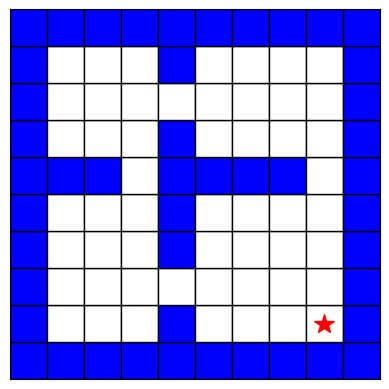

In [1]:
from four_room_grid import Four_room_grid,Policy
import matplotlib.pyplot as plt
grid = Four_room_grid()
grid.plot_grid()

iteration 5


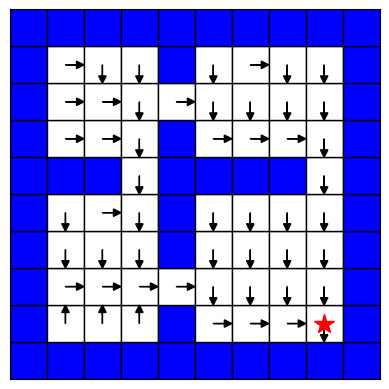

iteration 10


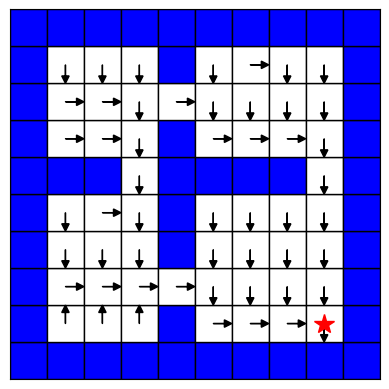

In [2]:
import numpy as np
def policy_iteration(n_iter = 10):
    policy = Policy()
    for iter in range(n_iter):
        if (iter+1) % 5 == 0:
            print(f'iteration {iter+1}')
            grid.plot_grid(policy.matrix)
        Q_pi = policy.calculate_Q_pi()
        new_policy = np.zeros((grid.n_navigable_states,grid.n_actions))
        for idx,state in enumerate(np.argmax(Q_pi, axis = 1)):
            new_policy[idx,state] = 1
        policy = Policy(new_policy)
    return policy

optimal_policy = policy_iteration()


In [3]:
g,A = grid.create_state_graph()


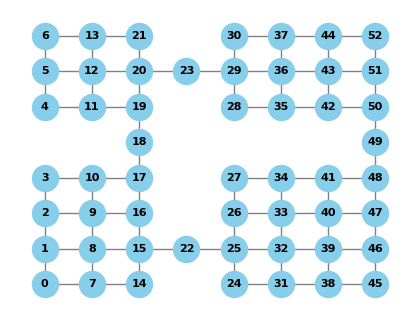

In [4]:
grid.plot_state_graph()

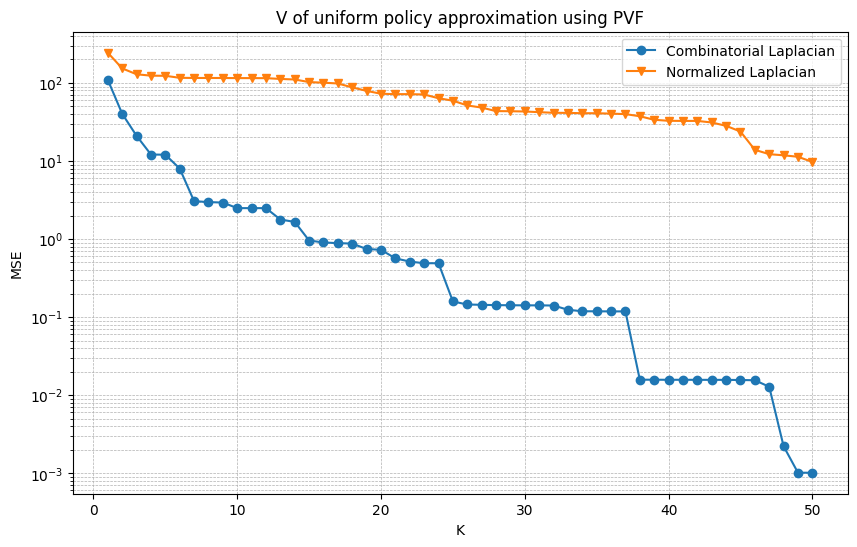

In [5]:
L = grid.laplacian_state()
norm_L = grid.normalized_laplacian_state()
U_combinatorial, _, _ = np.linalg.svd(L)
U_norm, _, _ = np.linalg.svd(norm_L)
k_vec = [k+1 for k in range(50)]
err_vec_combinatorial = []
err_vec_normalized = []
uniform_policy = Policy()
V_uniform = uniform_policy.calculate_V_pi()
for k in k_vec:
    phi = U_combinatorial[:,-k:]
    weights = np.linalg.solve(phi.T@phi, phi.T@V_uniform)
    V_predicted = phi @ weights
    err_vec_combinatorial.append(np.mean((V_predicted - V_uniform)**2))

    phi = U_norm[:,-k:]
    weights = np.linalg.solve(phi.T@phi, phi.T@V_uniform)
    V_predicted = phi @ weights
    err_vec_normalized.append(np.mean((V_predicted - V_uniform)**2))


plt.figure(figsize=(10, 6))
plt.plot(k_vec, err_vec_combinatorial, marker='o', label = 'Combinatorial Laplacian')
plt.plot(k_vec, err_vec_normalized, marker='v', label = 'Normalized Laplacian')
plt.yscale('log')
plt.title('V of uniform policy approximation using PVF')
plt.xlabel('K')
plt.ylabel('MSE')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()


In [6]:
g,A = grid.create_state_action_graph()

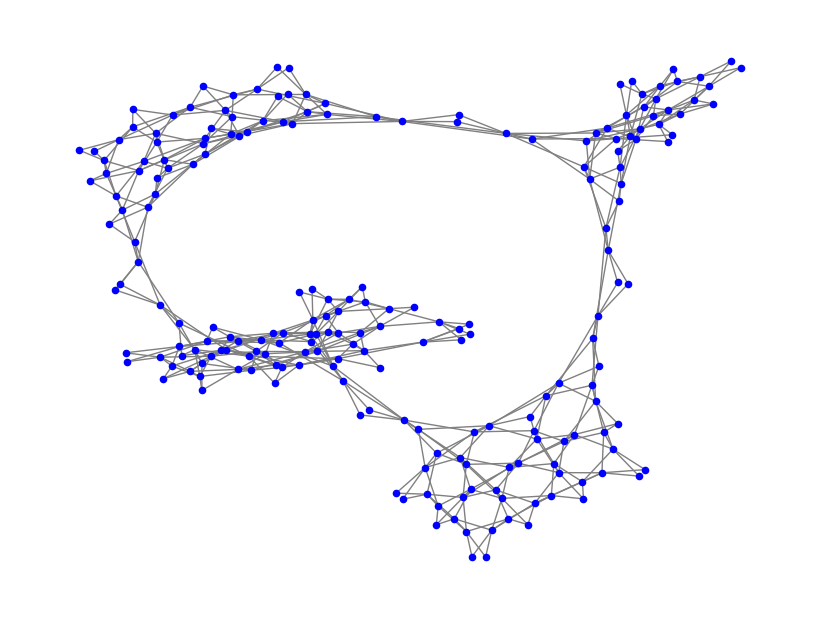

In [7]:
grid.plot_state_action_graph()

In [8]:
grid.set_policy(uniform_policy)

In [9]:
G,W = grid.create_state_action_graph(weighted = True)

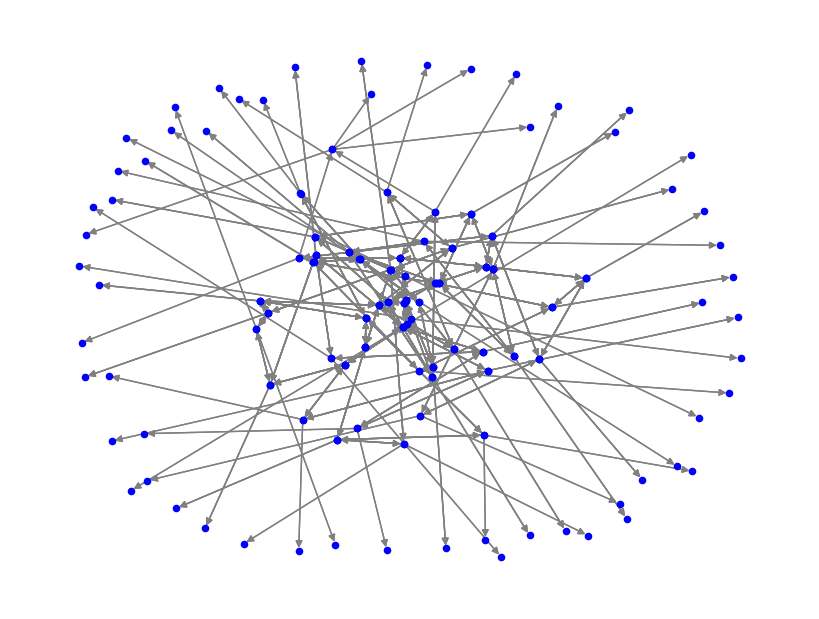

In [10]:
grid.plot_state_action_graph()

In [11]:
def approximate_Q_pi_using_PVF(k, target_pi, normalized = False, weight_policy = None, return_Q_target = False):
    grid = Four_room_grid()
    Q_target = target_pi.calculate_Q_pi(as_vector= True)
    if weight_policy is None:
        if normalized:
            L = grid.normalized_laplacian_state_action()
        else:
            L = grid.laplacian_state_action()
    else:
        grid.set_policy(weight_policy)
        if normalized:
            L = grid.normalized_laplacian_state_action(weighted = True)
        else:
            L = grid.laplacian_state_action(weighted= True)        

    U, _, _ = np.linalg.svd(L)
    phi = U[:,-k:]
    weights = np.linalg.solve(phi.T@phi, phi.T@Q_target)
    Q_predicted = phi @ weights
    
    if return_Q_target:
        return Q_predicted, Q_target
    else:
        return Q_predicted

In [12]:
def plot_approximation_error(target_pi, weight_policy):
    err_vec_weighted_normalized = []
    err_vec_unweighted_normalized = []
    err_vec_weighted = []
    err_vec_unweighted = []
    k_vec = [5,10,50,100]
    for k in k_vec:
        Q_pred, Q_target = approximate_Q_pi_using_PVF(k = k, target_pi= target_pi, weight_policy= weight_policy, normalized= True, return_Q_target= True)
        err_vec_weighted_normalized.append(np.mean((Q_pred - Q_target)**2))
        Q_pred, Q_target = approximate_Q_pi_using_PVF(k = k, target_pi= target_pi, normalized= True, return_Q_target= True)
        err_vec_unweighted_normalized.append(np.mean((Q_pred - Q_target)**2))
        Q_pred, Q_target = approximate_Q_pi_using_PVF(k = k, target_pi= target_pi, weight_policy= weight_policy, normalized= False, return_Q_target= True)
        err_vec_weighted.append(np.mean((Q_pred - Q_target)**2)) 
        Q_pred, Q_target = approximate_Q_pi_using_PVF(k = k, target_pi= target_pi, normalized= False, return_Q_target= True)
        err_vec_unweighted.append(np.mean((Q_pred - Q_target)**2))

    plt.figure(figsize=(10, 6))
    plt.plot(k_vec, err_vec_weighted_normalized, marker='o', label = 'Weighted using normalized Laplacian')
    plt.plot(k_vec, err_vec_unweighted_normalized, marker='v', label = 'Unweighted using normalized Laplacian')
    plt.plot(k_vec, err_vec_weighted, marker='s', label = 'Weighted using combinatorial Laplacian')
    plt.plot(k_vec, err_vec_unweighted, marker='*', label = 'Unweighted using combinatorial Laplacian')
    plt.yscale('log')
    plt.title('Q_pi  approximation')
    plt.xlabel('K')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()


### Optimal policy


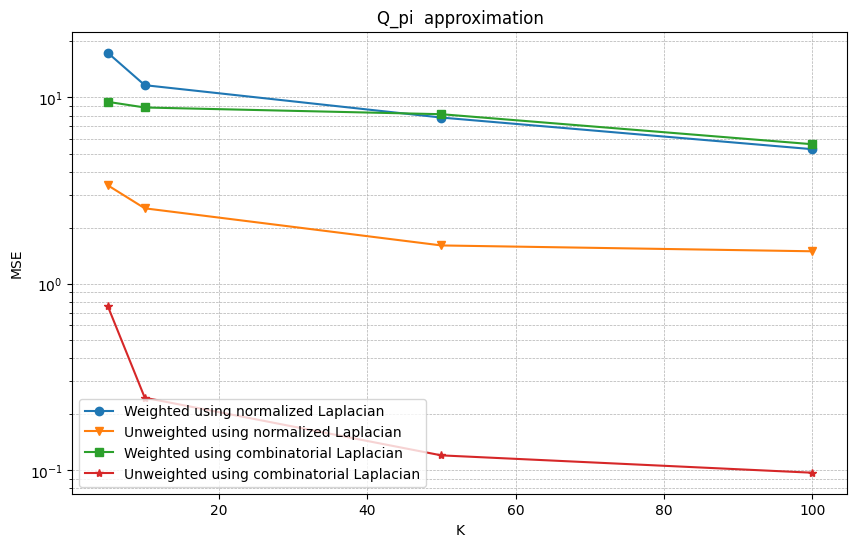

In [13]:
plot_approximation_error(target_pi = optimal_policy, weight_policy = optimal_policy)

### Uniform Policy 

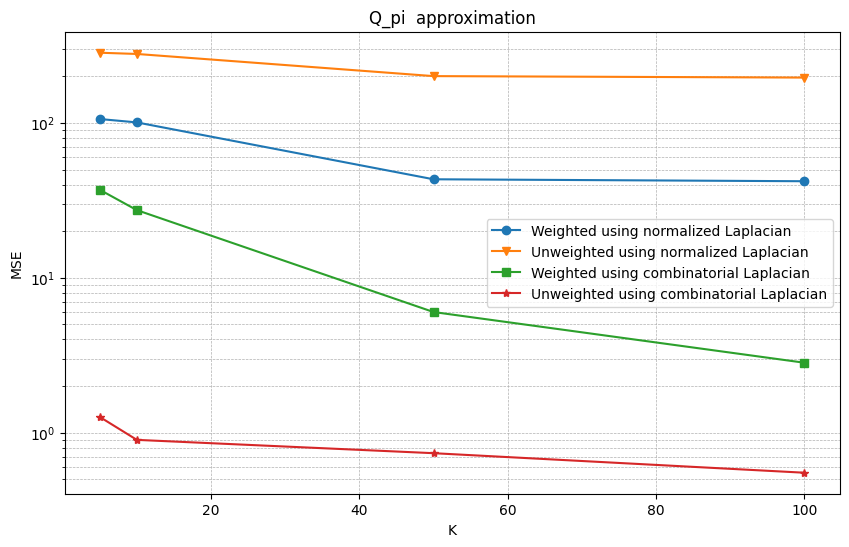

In [14]:
plot_approximation_error(target_pi = uniform_policy, weight_policy = uniform_policy)

### Random deterministic policy

In [15]:
def argmax_vector(array):
    idx_max = np.argmax(array)
    new_vec = np.zeros(len(array))
    new_vec[idx_max] = 1
    return new_vec

In [16]:
random_deterministic_policy_matrix = np.random.rand(grid.n_navigable_states, grid.n_actions)
random_deterministic_policy_matrix = np.array([argmax_vector(row) for row in random_deterministic_policy_matrix])

random_deterministic_policy = Policy(random_deterministic_policy_matrix)


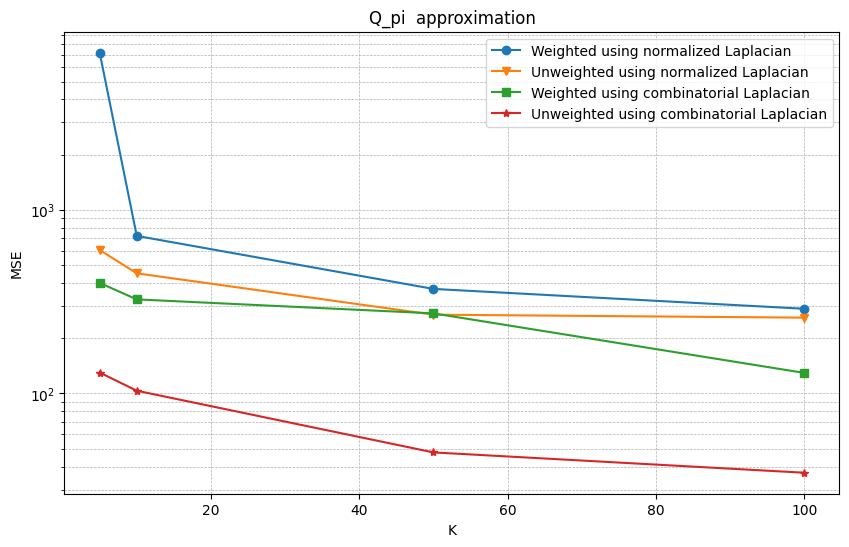

In [17]:
plot_approximation_error(target_pi = random_deterministic_policy, weight_policy = random_deterministic_policy)

### Random stochastic policy

In [18]:
random_stochastic_policy_matrix = np.random.rand(grid.n_navigable_states, grid.n_actions)
random_stochastic_policy_matrix = np.array([row/sum(row) for row in random_stochastic_policy_matrix])
random_stochastic_policy = Policy(random_stochastic_policy_matrix)

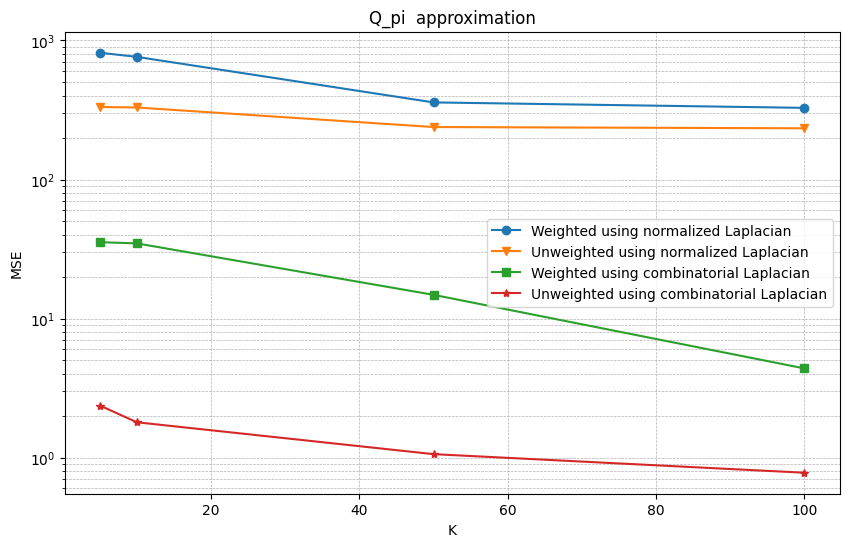

In [19]:
plot_approximation_error(target_pi = random_stochastic_policy, weight_policy = random_stochastic_policy)

In this way I am also predicting the Q function for the absorbing state, what if I ignore it?

In [20]:
def approximate_Q_pi_using_PVF(k, target_pi, normalized = False, weight_policy = None, return_Q_target = False):
    grid = Four_room_grid()
    Q_target = target_pi.calculate_Q_pi(as_vector= True)
    Q_target = np.delete(Q_target, np.s_[-32:-28])
    
    if weight_policy is None:
        if normalized:
            L = grid.normalized_laplacian_state_action()
        else:
            L = grid.laplacian_state_action()
    else:
        grid.set_policy(weight_policy)
        if normalized:
            L = grid.normalized_laplacian_state_action(weighted = True)
        else:
            L = grid.laplacian_state_action(weighted= True)        

    U, _, _ = np.linalg.svd(L)
    phi = U[:,-k:]
    phi = np.delete(phi, np.s_[-32:-28], 0)
    weights = np.linalg.solve(phi.T@phi, phi.T@Q_target)
    Q_predicted = phi @ weights
    
    if return_Q_target:
        return Q_predicted, Q_target
    else:
        return Q_predicted

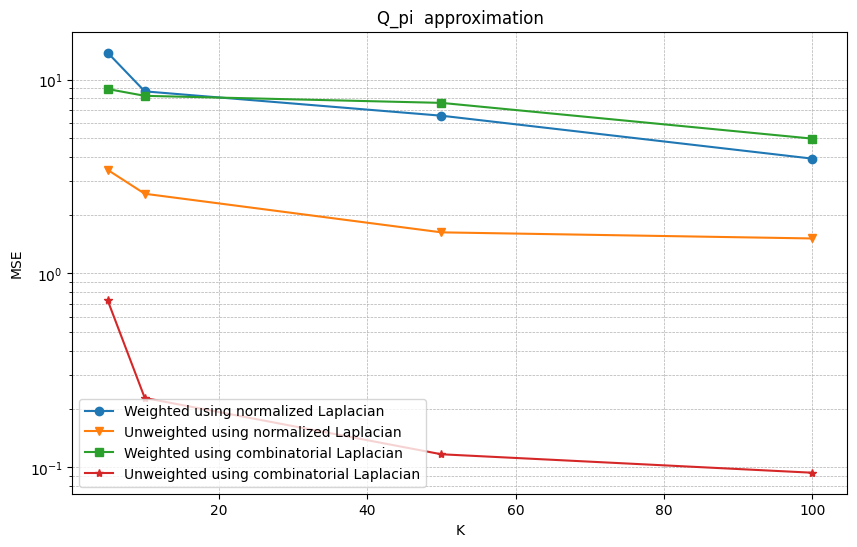

In [21]:
plot_approximation_error(target_pi = optimal_policy, weight_policy = optimal_policy)

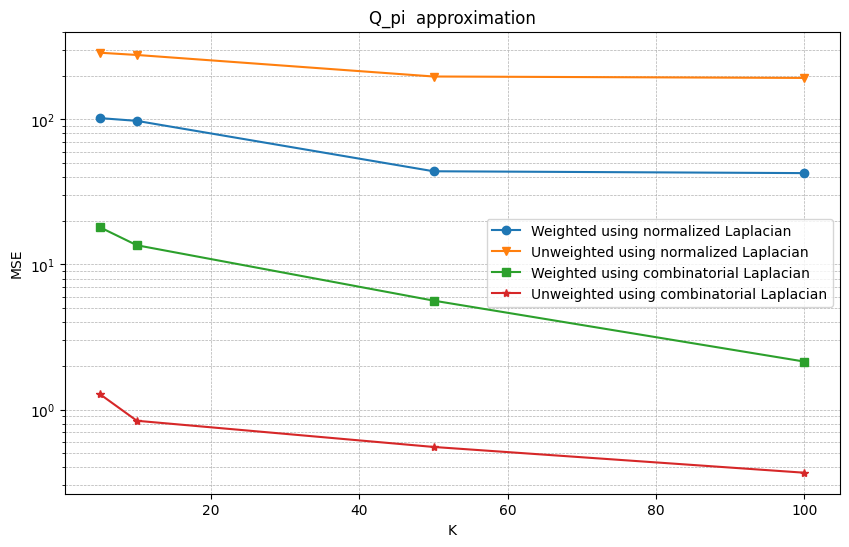

In [22]:
plot_approximation_error(target_pi = uniform_policy, weight_policy = uniform_policy)

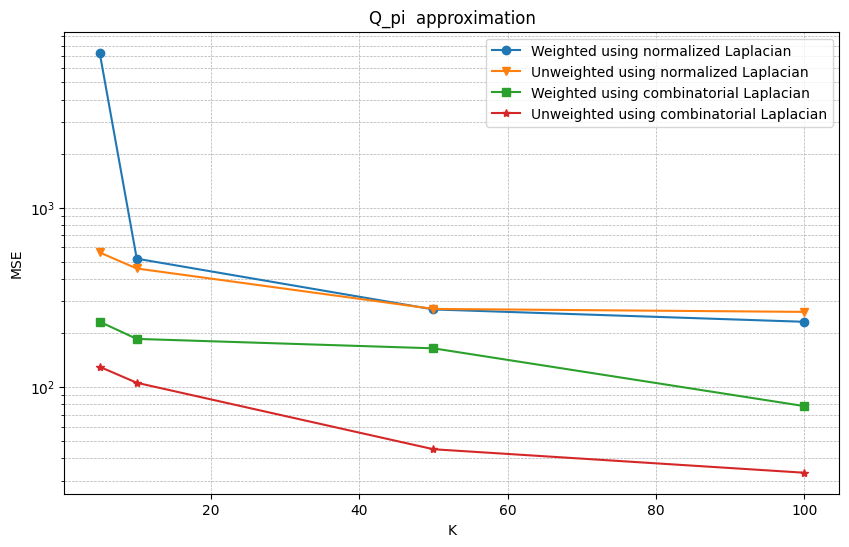

In [23]:
plot_approximation_error(target_pi = random_deterministic_policy, weight_policy = random_deterministic_policy)

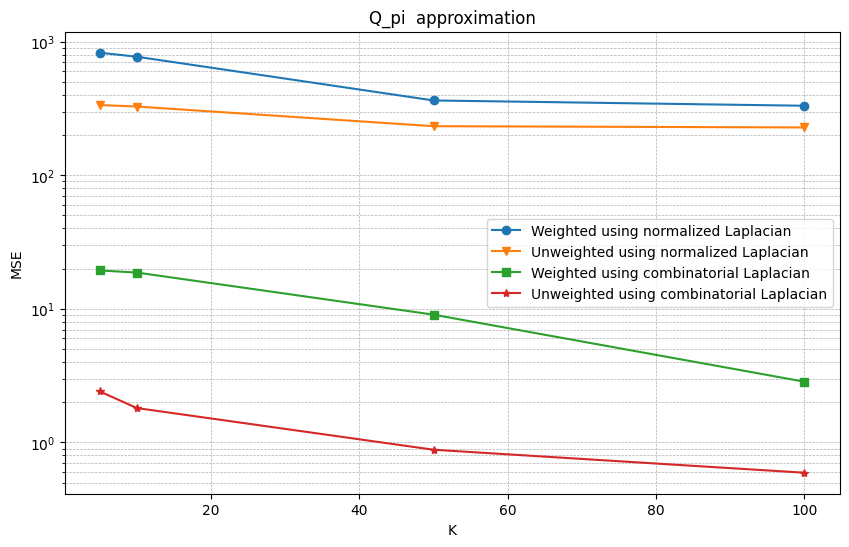

In [24]:
plot_approximation_error(target_pi = random_stochastic_policy, weight_policy = random_stochastic_policy)